In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
import cv2

from tqdm.auto import tqdm


from einops import rearrange

In [5]:
from mzr import *

In [47]:
class RepresentationNet(nn.Module):
    def __init__(self, env, latent_size=20):
        super().__init__()
        self.encoder = nn.Sequential(
            layer_init(nn.Conv2d(1, 10, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(10, 10, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(10, 10, 3, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(10, 10, 3, stride=2)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(20, latent_size)),
            nn.ReLU(),
        )
        self.latent_size = latent_size

    def forward(self, obs):
        return self.encoder(obs)

class GCPolicy(nn.Module):
    def __init__(self, env, latent_size=20, rnet=None):
        super().__init__()
        if rnet is None:
            rnet = RepresentationNet(env, latent_size)
        self.rnet = rnet

        self.n_outputs = env.action_space[0].n
        self.critic = nn.Sequential(
            layer_init(nn.Linear(2*latent_size, int(1.5*latent_size))),
            nn.ReLU(),
            layer_init(nn.Linear(int(1.5*latent_size), latent_size)),
            nn.ReLU(),
            layer_init(nn.Linear(latent_size, 1)),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(2*latent_size, int(1.5*latent_size))),
            nn.ReLU(),
            layer_init(nn.Linear(int(1.5*latent_size), latent_size)),
            nn.ReLU(),
            layer_init(nn.Linear(latent_size, self.n_outputs)),
        )
        
    def get_logits_values(self, obs, goal):
        latent = self.rnet(obs)
        latent_goal = torch.cat([latent, goal], dim=-1)
        logits, values = self.actor(latent_goal), self.critic(latent_goal)
        # if self.force_random:
        #     logits, values = torch.zeros_like(logits), torch.zeros_like(values)
        return logits, values

    def get_action_and_value(self, obs, goal, action=None):
        logits, values = self.get_logits_values(obs, goal)
        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), values

In [82]:
def loss_fn(goal, state_latent, strategy='euclidean'):
    if strategy=='euclidean':
        return (goal-state_latent).pow(2).mean(dim=-1)
    elif strategy=='dot':
        return torch.cosine_similarity(goal, state_latent, dim=-1)

In [98]:
batch_size = 32
latent_size = 2
env = MZRevenge(n_envs=batch_size)

rnet = RepresentationNet(env, latent_size)
policy = GCPolicy(env, latent_size, rnet=None) # keep separate rnet

opt = torch.optim.Adam(rnet.parameters(), lr=1e-3)


losses = []
pbar = tqdm(range(100))
for i in pbar:
    goal = torch.randn(batch_size, latent_size)

    _, obs, reward, done, info = env.reset()
    o = []
    for i in range(50):
        action, log_prob, entropy, values = policy.get_action_and_value(obs, goal)
        _, obs, reward, done, info = env.step(action.tolist())
        o.append(obs)
    o = torch.stack(o, dim=1)
    # o = o[:, -1]
    # print(o.shape)

    o_flat = rearrange(o, 'g t c h w -> (g t) c h w')
    latent = rnet(o_flat)
    latent = rearrange(latent, '(g t) l -> g t l', g=len(goal))
    # print(goal.shape, latent.shape)
    loss = loss_fn(goal[:, None, :], latent).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())
    pbar.set_postfix(loss=loss.item())


100%|██████████| 100/100 [03:29<00:00,  2.09s/it, loss=1.04]


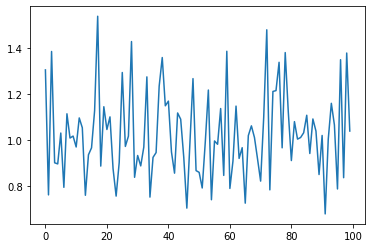

In [101]:
plt.plot(losses)